# **DISASTER DETECTION ON TWITTER WITH LSTM**


---

This notebook detects disaster-related tweets (binary classification), using a LSTM neural network and Transfer Learning with BERT network.

---

**REFERENCES**

The dataset is available here: https://www.kaggle.com/vstepanenko/disaster-tweets

BERT transfer learning tutorial: https://github.com/nlptown/nlp-notebooks/blob/master/Text%20classification%20with%20BERT%20in%20PyTorch.ipynb

## Importing libraries

In [ ]:
!pip install torchtext==0.4
!pip install transformers
#!pip install nlpaug

     |████████████████████████████████| 61kB 5.4MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
     |████████████████████████████████| 1.5MB 7.6MB/s 
     |████████████████████████████████| 2.9MB 28.6MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a065acce9e2dc5ef53e6dc21e06d9805f41933a879f4c23d8664353530f1883f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import nltk
#import nlpaug

nltk.download('stopwords')
from nltk.corpus import stopwords
set(stopwords.words('english'))
nltk.download('wordnet')
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
#from nlpaug.augmenter.word.context_word_embs import ContextualWordEmbsAug

import torch  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import transformers
from torchtext import data
from torch.utils.data import DataLoader, WeightedRandomSampler
from transformers.models.bert.tokenization_bert import BertTokenizer
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

import pandas as pd
import re
import numpy as np
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import logging

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Reproducing same results
SEED = 42

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip 'drive/My Drive/tweets.csv.zip'

Mounted at /content/drive
Archive:  drive/My Drive/tweets.csv.zip
  inflating: tweets.csv              


## Data augmentation

Just an attempt to balance classes before passing them to PyTorch. The attempt failed, because it introduced too much noise in the data (so **don't run this section**!!). 

The best way to deal with the imbalanced dataset is to weight classes in the loss function.

In [ ]:
df = pd.read_csv(r'drive/My Drive/tweets.csv.zip', index_col=0 )

print("Loaded ", len(df), " tweets.")
df.head(5)

Loaded  11370  tweets.


,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
print("Class 0: ", df['target'].where(df['target']==0).count())
print("Class 1: ", df['target'].where(df['target']==1).count())

Class 0:  9256
Class 1:  2114


In [ ]:
aug_df = df[['text', 'target']].copy()
aug_df.head(10)

,text,target
id,,
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
5,"If this child was Chinese, this tweet would ha...",0
6,Several houses have been set ablaze in Ngemsib...,1
7,Asansol: A BJP office in Salanpur village was ...,1
8,"National Security Minister, Kan Dapaah's side ...",0


In [ ]:
from sklearn.model_selection import train_test_split
SPLIT_SEED = 100
train, test, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=SPLIT_SEED)
print("Training set size: ", len(train), len(train_labels))
print("Test set size: ", len(test), len(test_labels))

Training set size:  9096 9096
Test set size:  2274 2274


**Augment the minority class in the Training Set**

Each sample of class 1 creates 4 distinct new samples, augmenting words with most similar words obtained with Embedding. In this way we increase the vocabulary of our training set with also similar words (that may appear also in the test set), hoping that this will improve the effectiveness of our model and help the network to better learn the imbalanced class.

We underlie that just the training set should be augmented, the test set should remain unchanged, otherwise we can bias the predictions on the test, since the network may have observed an augmented version of the one that we are testing.

(This may take some time).

In [ ]:
#Extract tweet text of minority class (1:=disaster tweets)
#min_class = aug_df.loc[aug_df['target'] == 1, 'text']
#min_class.head(10)

#Extract tweet texts of the minority class
maj_class = [x for x, y in zip(train, train_labels) if y == 0]
print("Size of class 0 in train set: ", len(maj_class))
min_class = [x for x, y in zip(train, train_labels) if y == 1]
print("Size of class 1 in train set: ", len(min_class))


#Instanciate nlp augmentator
aug = ContextualWordEmbsAug(model_path='bert-base-uncased')
augmented = []
i=0

for text in min_class:
  augmented_data_list = aug.augment(text,n=4)
  for augmented_data in augmented_data_list:
    augmented.append(augmented_data)
  print("Sample ", i, " augmented.")
  i += 1

print("Size of class 1 in train set: ", len(augmented))

Size of class 0 in train set:  7399
Size of class 1 in train set:  1697
Sample  0  augmented.
Sample  1  augmented.
Sample  2  augmented.
Sample  3  augmented.
Sample  4  augmented.
Sample  5  augmented.
Sample  6  augmented.
Sample  7  augmented.
Sample  8  augmented.
Sample  9  augmented.
Sample  10  augmented.
Sample  11  augmented.
Sample  12  augmented.
Sample  13  augmented.
Sample  14  augmented.
Sample  15  augmented.
Sample  16  augmented.
Sample  17  augmented.
Sample  18  augmented.
Sample  19  augmented.
Sample  20  augmented.
Sample  21  augmented.
Sample  22  augmented.
Sample  23  augmented.
Sample  24  augmented.
Sample  25  augmented.
Sample  26  augmented.
Sample  27  augmented.
Sample  28  augmented.
Sample  29  augmented.
Sample  30  augmented.
Sample  31  augmented.
Sample  32  augmented.
Sample  33  augmented.
Sample  34  augmented.
Sample  35  augmented.
Sample  36  augmented.
Sample  37  augmented.
Sample  38  augmented.
Sample  39  augmented.
Sample  40  augmen

**Add augmented data to the dataframe and save the new dataset**

In [ ]:
#Append the augmented data to the series
aug_s = pd.Series(augmented) 
train = train.append(aug_s, ignore_index=True)

#Append the targets to the series:
targets_1 = [1 for i in range(len(augmented))]
lab_s = pd.Series(targets_1) 
train_labels = train_labels.append(lab_s, ignore_index=True)

#Check that everything is correct
print("Data length: ", len(train))
print("Labels length: ", len(train_labels))

#Save training set as csv
df_data = { 'text': train, 'target': train_labels } 
aug_df = pd.DataFrame(df_data) 
#Shuffle the dataset to avoid having all the augmented samples near each other
aug_df=shuffle(aug_df,random_state=100)
aug_df.head(5)
#Save to csv on My Drive
aug_df.to_csv('drive/My Drive/training.csv', index=True)

Data length:  15884
Labels length:  15884


In [ ]:
print(len(test), len(test_labels))
df_test_data = { 'text': test, 'target': test_labels } 
df_test = pd.DataFrame(df_test_data) 
print(df_test.count())
df_test.head(3)
df_test.to_csv('drive/My Drive/testing.csv', index=True)

2274 2274
text      2274
target    2274
dtype: int64


## Loading and preparing the dataset

In this section we: 

*   load the dataset using `torch.data.TabularDataset`
*   preprocess and tokenize tweet texts using `nltk` tools 
*   split the dataset into training and validation
*   build the vocabulary for the Embedding layer





In [ ]:
def preprocess(text):

  #do some preprocessing and cleaning
  text = text.encode('ascii', 'ignore').decode('ascii') #deEmojify
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"#", " ", text)
  text = re.sub('\s+', ' ', text).strip() #remove multiple white spaces
  text = re.sub(r'[^\w\d\s\']+', '', text) #remove symbols

  #tokenize with Twitter tokenizer and remove upper case
  tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
  tokens = tknzr.tokenize(text) #now we have a list of tokens
  
  #remove stop words
  eng_stopwords = stopwords.words('english')
  tokens = [w for w in tokens if w not in eng_stopwords]  

  tokens = [w for w in tokens if w.isalpha() or w.isdigit()]

  #stemming
  stemmer = SnowballStemmer("english") #snowball is faster, improvement of Porter stemmer
  tokens = [stemmer.stem(w) for w in tokens]

  
  return tokens


In [ ]:
TEXT = data.Field(tokenize=preprocess,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

#fields of the csv are id, keyword, location, text, target
fields = [(None, None), (None, None), (None, None), ('text',TEXT), ('target',LABEL)]
dataset = data.TabularDataset(path = 'tweets.csv',
                              format = 'csv',
                              fields = fields,
                              skip_header = True)
print(dataset.fields)


{None: None, 'text': <torchtext.data.field.Field object at 0x7fc23a34d7f0>, 'target': <torchtext.data.field.LabelField object at 0x7fc23a34d828>}


In [ ]:
#Print an example
print("Training set example: ",)
print("Label: ", dataset[0].target)
print("Tokenized text: ", dataset[0].text) #the text has been already preprocessed
print(type(dataset[0].target))


Training set example: 
Label:  1
Tokenized text:  ['communal', 'violenc', 'bhainsa', 'telangana', 'stone', 'pelt', 'muslim', 'hous', 'hous', 'vehicl', 'set', 'ablaz']
<class 'str'>


**Remove empty samples**

We noticed that our dataset contained also tweets with strange symbols (maybe in Russian language?); after the preprocessing those tweets remained empty, because only alphanumeric characters were allowed, and this causes a problem during the training of the network, therefore we decided to remove them from the dataset.

In [ ]:
def drop_nan(dataset):
  for index,s in enumerate(dataset):
    if len(s.text)==0:
      #remove row from the dataset (because the tweet contains only strange symbols.)
      del dataset.examples[index]
      print("Data sample ", index, " deleted.")
  return dataset

dataset = drop_nan(dataset)
dataset = drop_nan(dataset)


Data sample  87  deleted.
Data sample  336  deleted.
Data sample  686  deleted.
Data sample  1497  deleted.
Data sample  4445  deleted.
Data sample  8024  deleted.
Data sample  10856  deleted.
Data sample  8024  deleted.


**Splitting into training, validation and test set**

The training set is used to train the neural network, the validation is used to tune parameters and assess the performances of the classifier; the test set remains unseen to the network during the training, and it is used to measure the real performances of the network on new data.

In [ ]:
#Split the dataset into training, validation and test set
train_data, test_data = dataset.split(split_ratio=0.8, random_state = random.seed(SEED))
train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(SEED))

print("Size of the dataset: ", len(dataset))
print("Size of the training set: ", len(train_data))
print("Size of the validation set: ", len(valid_data))
print("Size of the test set: ", len(test_data))

Size of the dataset:  11362
Size of the training set:  6363
Size of the validation set:  2727
Size of the test set:  2272


In [ ]:
#Counting positives and negatives samples:
def get_class_size(my_dataset):
  non_disasters, disasters = 0, 0
  for d in my_dataset:
    if d.target=='0':
      non_disasters += 1
    else:
      disasters += 1

  print("Number of samples: ", len(my_dataset) )
  print("Number of non-disaster tweets (class 0): ", non_disasters)
  print("Number of disaster-related tweets (class 1): ", disasters)
  print("Ratio: ", non_disasters/disasters)

  return non_disasters,disasters

class0_size, class1_size = get_class_size(train_data) #Very imbalanced dataset!!!

Number of samples:  6363
Number of non-disaster tweets (class 0):  5206
Number of disaster-related tweets (class 1):  1157
Ratio:  4.499567847882455


**Building the vocabulary (not pretrained)**

In [ ]:
#TEXT.build_vocab(train_data,vectors = "glove.6B.100d")  
#TEXT.build_vocab(train_data,vectors = "glove.twitter.27B.200d") 
TEXT.build_vocab(train_data)    
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label (0 and 1)
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 12102
Size of LABEL vocabulary: 2
[('amp', 334), ('like', 320), ('fire', 291), ('peopl', 290), ('get', 262), ('one', 233), ('year', 191), ('need', 184), ('us', 182), ('time', 178), ('go', 169), ('say', 157), ('new', 156), ('know', 155), ('bomb', 153), ('day', 146), ('im', 142), ('2', 139), ('want', 139), ('would', 136)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fc23a35d780>>, {'<unk>': 0, '<pad>': 1, 'amp': 2, 'like': 3, 'fire': 4, 'peopl': 5, 'get': 6, 'one': 7, 'year': 8, 'need': 9, 'us': 10, 'time': 11, 'go': 12, 'say': 13, 'new': 14, 'know': 15, 'bomb': 16, 'day': 17, 'im': 18, '2': 19, 'want': 20, 'see': 21, 'would': 22, 'kill': 23, 'attack': 24, 'think': 25, 'iran': 26, '1': 27, 'come': 28, 'first': 29, 'caus': 30, 'man': 31, 'take': 32, 'back': 33, 'use': 34, 'look': 35, 'burn': 36, 'emerg': 37, 'make': 38, 'storm': 39, 'love': 40, 'tri': 41, 'help': 42, 'two': 43, 'death': 44, 'today': 45, 'drown': 46, 'pl

**Define iterators to load data in batches**

In [ ]:
#set batch size
BATCH_SIZE = 16 #best
#BATCH_SIZE = 32

#Load an iterator. We have to sort them by length since it will be needed for the padding
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)
test_iterator = data.Iterator(test_data, batch_size=BATCH_SIZE, sort_key = lambda x: len(x.text),
    sort_within_batch=True, device = device )

## CUSTOM LSTM LEARNING

### LSTM architecture and functions

**Defining the neural network**

In [ ]:
class Net(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, hidden2_dim, output_dim, n_layers, 
                 bidirectional, dropout, dropout_layer):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        #self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.fc = nn.Linear(hidden_dim * 2, hidden2_dim)

        #New layers to make nn deeper
        self.dropout = nn.Dropout(dropout_layer)
        self.fc2 = nn.Linear(hidden2_dim, output_dim)

        #activation function used for binary classification
        self.act = nn.Sigmoid()

      

    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        #New layers
        dense_outputs=self.dropout(dense_outputs)
        dense_outputs=self.fc2(dense_outputs)
        
        outputs=self.act(dense_outputs)
        
        return outputs

**Defining the evaluation metric**

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

**Train function**

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase. Weights are updated and dropout layers activated
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text

        #convert to 1D tensor
        predictions = model(text, text_lengths.cpu()).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.target)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.target)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation function**

In [ ]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    preds = []
    true = []

    #no weight update and dropout layers deactivated
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths.cpu()).squeeze()
            preds.append(predictions)
            true.append(batch.target)
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.target)
            acc = binary_accuracy(predictions, batch.target)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, true

In [ ]:
def train_early_stop(model, train_iterator, valid_iterator, optimizer, criterion, n_epochs, patience):
  #Initialization
  best_valid_loss = float('inf')
  counter = 0

  for epoch in range(n_epochs):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    #evaluate the model
    valid_loss, valid_acc, preds, true = evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    #print epoch info
    print("\nEPOCH ", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    #early stopping
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      counter = 0
      #save the best model (the current one)
      torch.save(model.state_dict(), 'lstm_model.pt')
    else:
      counter += 1
    if counter == patience:
      break
    
  #return full training history
  return train_losses, train_accuracies, valid_losses, valid_accuracies

### LSTM training 

**Instanciating a model**

`pos_weight` > 1 will increase the recall while `pos_weight` < 1 will increase the precision.

**PRECISION** = TP / (TP+FP) (Decrease FP=> Increase Precision)

**RECALL** = TP / (TP+FN) (Decrease FN => Increase Recall)

For our purposes (detect disaster tweets to improve emergency awareness), we want to increase the recall, the portion of actual positives that is correctly identified. False positives, infact, are less important than false negatives, because a false positive is just a false alarm, while a false negative implies that we are loosing information about a disaster that is happening in the world, failing the task (detect disasters to provide fast help). 

`pos_weight= |majority class| / |minority class|`

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 200
num_hidden_nodes = 64
num_hidden2_nodes = 50
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.3 #inner dropout (LSTM)
dropout_layer = 0.3
lr = 0.0005

#instanciate an empty model
model = Net(size_of_vocab, embedding_dim, num_hidden_nodes, num_hidden2_nodes, 
            num_output_nodes, num_layers, bidirectional = True, dropout = dropout, 
            dropout_layer = dropout_layer)

print(model)

#define optimizer and loss
optimizer = optim.Adam(model.parameters(),lr=lr)

#without weighting the loss function
#criterion = nn.BCELoss()
#weighting the loss function (to deal with imbalanced classes)
pos_weight = torch.tensor([class0_size/class1_size])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#move the model to GPU if available
model = model.to(device)
criterion = criterion.to(device)

Net(
  (embedding): Embedding(12102, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=50, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (act): Sigmoid()
)


In [ ]:
#patience=x means that if after x epochs the loss does not improve, the training stops (early stopping)
train_losses, train_accuracies, valid_losses, valid_accuracies = train_early_stop(model, train_iterator,
                                                                                  valid_iterator, optimizer,
                                                                                  criterion, n_epochs=100, 
                                                                                  patience=12)


EPOCH  0
	Train Loss: 1.086 | Train Acc: 81.04%
	 Val. Loss: 1.018 |  Val. Acc: 83.90%

EPOCH  1
	Train Loss: 0.968 | Train Acc: 86.24%
	 Val. Loss: 1.020 |  Val. Acc: 85.93%

EPOCH  2
	Train Loss: 0.928 | Train Acc: 90.40%
	 Val. Loss: 0.999 |  Val. Acc: 86.92%

EPOCH  3
	Train Loss: 0.910 | Train Acc: 92.35%
	 Val. Loss: 1.009 |  Val. Acc: 86.99%

EPOCH  4
	Train Loss: 0.898 | Train Acc: 93.48%
	 Val. Loss: 1.011 |  Val. Acc: 87.57%

EPOCH  5
	Train Loss: 0.895 | Train Acc: 93.97%
	 Val. Loss: 0.998 |  Val. Acc: 88.23%

EPOCH  6
	Train Loss: 0.892 | Train Acc: 94.23%
	 Val. Loss: 0.992 |  Val. Acc: 86.29%

EPOCH  7
	Train Loss: 0.893 | Train Acc: 93.97%
	 Val. Loss: 1.003 |  Val. Acc: 85.75%

EPOCH  8
	Train Loss: 0.892 | Train Acc: 94.19%
	 Val. Loss: 0.997 |  Val. Acc: 85.88%

EPOCH  9
	Train Loss: 0.890 | Train Acc: 94.41%
	 Val. Loss: 1.002 |  Val. Acc: 88.08%

EPOCH  10
	Train Loss: 0.883 | Train Acc: 95.21%
	 Val. Loss: 0.994 |  Val. Acc: 85.11%

EPOCH  11
	Train Loss: 0.884 |

### LSTM Testing

Using a test set (unseen by the network), we can really understand how much our network is able to generalize.

**Load the model**

In [ ]:
custom_model = Net(size_of_vocab, embedding_dim, num_hidden_nodes, num_hidden2_nodes, 
                   num_output_nodes, num_layers, bidirectional = True, 
                   dropout = dropout, dropout_layer = dropout_layer)
custom_model.load_state_dict(torch.load('lstm_model.pt'))
custom_model = custom_model.to(device)
print(custom_model)


Net(
  (embedding): Embedding(12102, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=50, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (act): Sigmoid()
)


**Inspect validation results**

First, we want to check results of validation step. Accuracy in fact, is not enough to understand the performances, expecially with imbalanced datasets; we want to precisely know how the model is predicting with respect to each class.

NOTE: This is not testing

0.875
CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2201
           1       0.70      0.62      0.66       526

    accuracy                           0.87      2727
   macro avg       0.80      0.78      0.79      2727
weighted avg       0.87      0.87      0.87      2727



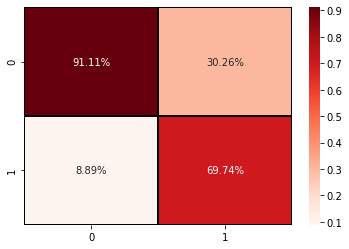

In [ ]:
#inspect validation results
loss, acc, predictions, true = evaluate(custom_model, valid_iterator, criterion)
print(acc)

#classification report
print("CLASSIFICATION REPORT\n")
y_pred = []
y_true = []

for batch in predictions:
  for el in batch:
    y_pred.append(int(el.round().item()))

for batch in true:
  for el in batch:
    y_true.append(int(el.item()))
  
print(classification_report(y_true, y_pred))
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Reds', linecolor='black', linewidths=0.5)

**Testing the network**

Now we are ready to use our LSTM to predict on the test data.

0.8670774647887324
CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1841
           1       0.67      0.58      0.62       431

    accuracy                           0.87      2272
   macro avg       0.79      0.76      0.77      2272
weighted avg       0.86      0.87      0.86      2272



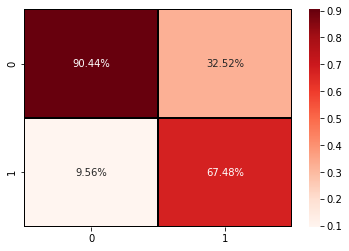

In [ ]:
#predict on test_set
loss, acc, predictions, true = evaluate(custom_model, test_iterator, criterion)
print(acc)

#classification report
print("CLASSIFICATION REPORT\n")
y_pred = []
y_true = []

for batch in predictions:
  batch_list = batch.squeeze().tolist()
  for p in batch_list:
    y_pred.append(int(round(p)))

for batch in true:
  for el in batch:
    y_true.append(int(el.item()))
  
print(classification_report(y_true, y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Reds', linecolor='black', linewidths=0.5)

## TRANSFER LEARNING with BERT

### Preparing data for BERT

We use the already preprocessed dataset (since BERT tokenizer does not remove emojis, stopwords, etc), split into training, validation and test set, and convert them into BERT objects.

In [ ]:
#set batch size
BATCH_SIZE = 16 #with bigger batch cuda gets out of memory

In [ ]:
print(dataset.fields)
print(dataset[0].text)
target_names = ['0','1']
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{None: None, 'text': <torchtext.data.field.Field object at 0x7fc23a34d7f0>, 'target': <torchtext.data.field.LabelField object at 0x7fc23a34d828>}
['communal', 'violenc', 'bhainsa', 'telangana', 'stone', 'pelt', 'muslim', 'hous', 'hous', 'vehicl', 'set', 'ablaz']
{'0': 0, '1': 1}


In [ ]:
BERT_MODEL = "bert-large-uncased" #best
#BERT_MODEL = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [ ]:
train_data, test_data = dataset.split(split_ratio=0.8, random_state = random.seed(SEED))
train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(SEED))

In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=150
#MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

BERT_train = convert_examples_to_inputs(train_data.text, train_data.target, MAX_SEQ_LENGTH, tokenizer, verbose=0)
BERT_valid = convert_examples_to_inputs(valid_data.text, valid_data.target, MAX_SEQ_LENGTH, tokenizer, verbose=0)
BERT_test = convert_examples_to_inputs(test_data.text, test_data.target, MAX_SEQ_LENGTH, tokenizer, verbose=0)

In [ ]:
print(BERT_train[1].text)
print("Train size: ", len(BERT_train))
print("Validation size: ", len(BERT_valid))
print("Test size: ", len(BERT_test))

['bad', 'dream', '107', 'fatal']
Train size:  6363
Validation size:  2727
Test size:  2272


In [ ]:
def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([int(f.label_id) for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader


train_dataloader = get_data_loader(BERT_train, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
valid_dataloader = get_data_loader(BERT_valid, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(BERT_test, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### BERT model instanciation and training

**Importing the pretrained BERT model**

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

01/06/2021 17:29:41 - INFO - filelock -   Lock 140472158301264 acquired on /root/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.d4d29047141693194a1c377423a9a58b3ffdd39ed177b3a9b2ac9bce9e6638d9.lock


01/06/2021 17:29:41 - INFO - filelock -   Lock 140472158301264 released on /root/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.d4d29047141693194a1c377423a9a58b3ffdd39ed177b3a9b2ac9bce9e6638d9.lock


01/06/2021 17:29:41 - INFO - filelock -   Lock 140472118208608 acquired on /root/.cache/huggingface/transformers/1d959166dd7e047e57ea1b2d9b7b9669938a7e90c5e37a03961ad9f15eaea17f.fea64cd906e3766b04c92397f9ad3ff45271749cbe49829a079dd84e34c1697d.lock


01/06/2021 17:30:06 - INFO - filelock -   Lock 140472118208608 released on /root/.cache/huggingface/transformers/1d959166dd7e047e57ea1b2d9b7b9669938a7e90c5e37a03961ad9f15eaea17f.fea64cd906e3766b04c92397f9ad3ff45271749cbe49829a079dd84e34c1697d.lock


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

**Defining the evaluation function used during training**

In [ ]:
def b_evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids, return_dict=False)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [ ]:
#Defining hyperparameters, optimizer and scheduler
GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 50
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps = num_train_steps)


**Training the network**

In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm 
from sklearn.metrics import classification_report, precision_recall_fscore_support

#Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = ""
MODEL_FILE_NAME = "bert_model.bin"
PATIENCE = 6

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        loss, preds = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids, return_dict=False)
      


        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    dev_loss, true_labels, pred_labels = b_evaluate(model, valid_dataloader)
    
    print("Loss history:", loss_history)
    print("Validation loss:", dev_loss)


    dev_accuracy = np.mean(pred_labels == true_labels)
    print("Validation accuracy:", dev_accuracy)
    print("----Impr:", no_improvement)
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        #torch.save(model.state_dict(), 'bert_model.pt')
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), 'bert_model.pt')
    else:
        no_improvement += 1

    loss_history.append(dev_loss)
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]


Loss history: []
Validation loss: 0.32354205284725157
Validation accuracy: 0.8690869086908691
----Impr: 0


Epoch:   2%|▏         | 1/50 [11:15<9:11:53, 675.79s/it]


Loss history: [0.32354205284725157]
Validation loss: 0.32210486018431117
Validation accuracy: 0.8734873487348734
----Impr: 0


Epoch:   4%|▍         | 2/50 [22:36<9:01:46, 677.21s/it]


Loss history: [0.32354205284725157, 0.32210486018431117]
Validation loss: 0.2874643024253218
Validation accuracy: 0.8925559222588926
----Impr: 0


Epoch:   6%|▌         | 3/50 [33:55<8:50:55, 677.77s/it]

Epoch:   8%|▊         | 4/50 [45:09<8:38:43, 676.60s/it]


Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218]
Validation loss: 0.3978146127158264
Validation accuracy: 0.8932893289328933
----Impr: 0


Epoch:  10%|█         | 5/50 [56:22<8:26:43, 675.64s/it]


Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218, 0.3978146127158264]
Validation loss: 0.4656850261428551
Validation accuracy: 0.885955262192886
----Impr: 1


Epoch:  12%|█▏        | 6/50 [1:07:35<8:14:47, 674.72s/it]


Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218, 0.3978146127158264, 0.4656850261428551]
Validation loss: 0.37217884201403945
Validation accuracy: 0.8907224055738907
----Impr: 2


Epoch:  14%|█▍        | 7/50 [1:18:48<8:03:13, 674.27s/it]


Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218, 0.3978146127158264, 0.4656850261428551, 0.37217884201403945]
Validation loss: 0.554734793144458
Validation accuracy: 0.865053171983865
----Impr: 3


Epoch:  16%|█▌        | 8/50 [1:30:02<7:51:50, 674.06s/it]


Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218, 0.3978146127158264, 0.4656850261428551, 0.37217884201403945, 0.554734793144458]
Validation loss: 0.4163807382894277
Validation accuracy: 0.8954895489548955
----Impr: 4



Loss history: [0.32354205284725157, 0.32210486018431117, 0.2874643024253218, 0.3978146127158264, 0.4656850261428551, 0.37217884201403945, 0.554734793144458, 0.4163807382894277]
Validation loss: 0.4346564058759059
Validation accuracy: 0.8764209754308764
----Impr: 5
No improvement on development set. Finish training.


### Testing BERT

In [ ]:
model_state_dict = torch.load('bert_model.pt', map_location=lambda storage, loc: storage)
bert_model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
bert_model.to(device)

bert_model.eval()

print("Predicting on training set...")
_, train_correct, train_predicted = b_evaluate(bert_model, train_dataloader)
print("Predicting on validation set...")
_, dev_correct, dev_predicted = b_evaluate(bert_model, valid_dataloader)
print("Predicting on test set...")
_, test_correct, test_predicted = b_evaluate(bert_model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)
print("Accuracy on test set: ", bert_accuracy)

print(classification_report(test_correct, test_predicted, target_names=target_names))

Predicting on training set...



Predicting on validation set...



Predicting on test set...



Training performance: (0.964010686782964, 0.964010686782964, 0.964010686782964, None)
Development performance: (0.8925559222588926, 0.8925559222588926, 0.8925559222588926, None)
Test performance: (0.8820422535211268, 0.8820422535211268, 0.8820422535211269, None)
Accuracy on test set:  0.8820422535211268
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1841
           1       0.71      0.65      0.68       431

    accuracy                           0.88      2272
   macro avg       0.81      0.79      0.80      2272
weighted avg       0.88      0.88      0.88      2272



01/06/2021 20:24:14 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


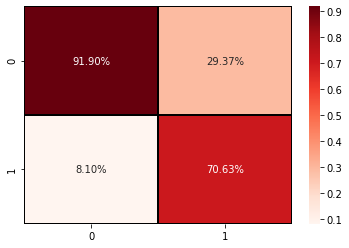

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_correct, test_predicted))
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Reds', linewidths=0.5, linecolor='black')